In [1]:
import numpy as np

import scipy.io
import matplotlib.pyplot as plt
from scipy.interpolate import interp1d

import scipy.signal

from torch.utils.data import DataLoader, Dataset
import torch.nn as nn
import torch.nn.functional as F

from mne import create_info
from mne.io import RawArray
from mne.time_frequency import tfr_array_morlet

from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import RobustScaler
from scipy.ndimage import gaussian_filter1d

import pypickle



In [2]:
CHANNELS_NUM = 62        # Number of channels in ECoG data
WAVELET_NUM = 40         # Number of wavelets in the frequency range
SAMPLE_RATE = 100        # Final sampling rate for finger flex and ecog data
time_delay_secs = 0.2    # Time delay hyperparameter

In [3]:
def finger_flex_preprocess(finger_flex, original_hz=1000, actual_hz=25, upsampled_hz=SAMPLE_RATE):
    
    downscaling_ratio = original_hz // actual_hz
    finger_flex = finger_flex[:, ::downscaling_ratio]

    print(upsampled_hz)

    # Time vectors for interpolation
    old_time = np.linspace(0, finger_flex.shape[1] - 1, num=finger_flex.shape[1])
    new_time = np.linspace(0, finger_flex.shape[1] - 1, num=int(finger_flex.shape[1] * (upsampled_hz / actual_hz)))

    # Apply cubic interpolation
    interpolator = interp1d(old_time, finger_flex, kind="cubic", axis=1)
    finger_flex_interp = interpolator(new_time)

    scaler = MinMaxScaler(feature_range=(0, 1))
    finger_flex_scaled = scaler.fit_transform(finger_flex_interp.T).T

    return finger_flex_scaled


In [4]:
def ecog_preprocess(train):
    original_sfreq = 1000
    ch_names = [f"ch{i}" for i in range(1, 63)]
    ch_types = ["ecog"] * 62  # Mark all channels as ECoG
    
    train = (train - np.mean(train, axis=1, keepdims=True)) / np.std(train, axis=1, keepdims=True)
    medians = np.median(train, axis=0, keepdims=True)
    train = train - medians

    info = create_info(ch_names=ch_names, sfreq=original_sfreq, ch_types=ch_types)

    raw = RawArray(train, info)
    raw.filter(l_freq=40, h_freq=300, fir_design='firwin')
    raw.notch_filter(freqs=[50, 100, 150, 200, 250, 300, 350, 400, 450], fir_design='firwin')

    X = raw.get_data()

    X = X[np.newaxis, :, :]

    X_spectrogram = tfr_array_morlet(
        X, sfreq=original_sfreq, freqs=np.logspace(np.log10(40), np.log10(300), WAVELET_NUM), output="power"
    )

    X_spectrogram = X_spectrogram[0]
    
    downscaling_ratio = original_sfreq // SAMPLE_RATE
    X_spectrogram = X_spectrogram[:, :, ::downscaling_ratio]

    num_channels, num_freqs, num_time_steps = X_spectrogram.shape
    X_spectrogram = X_spectrogram.T.reshape(-1, num_freqs*num_channels)

    scaler = RobustScaler(unit_variance=True, quantile_range=(0.1, 0.9))

    X_spectrogram_scaled = scaler.fit_transform(X_spectrogram)
    X_spectrogram_scaled = X_spectrogram_scaled.reshape(-1, num_freqs, num_channels).T

    print("Scaled Spectrogram Shape:", X_spectrogram_scaled.shape)

    return X_spectrogram_scaled

In [5]:
def crop_for_time_delay(finger_flex, spectrogramms, time_delay_sec=time_delay_secs, sample_rate=SAMPLE_RATE):

    time_delay = int(time_delay_sec*sample_rate)
    # The first time_delay seconds of finger flex data have no corresponding spectrograms
    finger_flex_cropped = finger_flex[..., time_delay:] 
    # The last time_delay seconds of spectrograms have no corresponding finger flex data
    spectrogramms_cropped = spectrogramms[..., :spectrogramms.shape[2] - time_delay]
    return finger_flex_cropped, spectrogramms_cropped

In [6]:
data = scipy.io.loadmat(f'BCI_Competion4_dataset4_data_fingerflexions/sub1_comp.mat')

finger_flex = data['train_dg'].astype('float32').T
finger_flex = finger_flex_preprocess(finger_flex)
print("Shape:", finger_flex.shape)

100
Shape: (5, 40000)


In [7]:
train = data['train_data'].astype('float32').T
X_spectrogram = ecog_preprocess(train)
print("Shape:", X_spectrogram.shape)

Creating RawArray with float64 data, n_channels=62, n_times=400000
    Range : 0 ... 399999 =      0.000 ...   399.999 secs
Ready.
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 40 - 3e+02 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 40.00
- Lower transition bandwidth: 10.00 Hz (-6 dB cutoff frequency: 35.00 Hz)
- Upper passband edge: 300.00 Hz
- Upper transition bandwidth: 75.00 Hz (-6 dB cutoff frequency: 337.50 Hz)
- Filter length: 331 samples (0.331 s)



[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.1s


Filtering raw data in 1 contiguous segment
Setting up band-stop filter

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandstop filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower transition bandwidth: 0.50 Hz
- Upper transition bandwidth: 0.50 Hz
- Filter length: 6601 samples (6.601 s)



[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.1s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:   20.5s


Scaled Spectrogram Shape: (62, 40, 40000)
Shape: (62, 40, 40000)


In [8]:
finger_flex_cropped, X_spectrogram_cropped = crop_for_time_delay(finger_flex, X_spectrogram)

print(finger_flex_cropped.shape, X_spectrogram_cropped.shape)

(5, 39980) (62, 40, 39980)


In [9]:
data_val = scipy.io.loadmat(f'BCI_Competion4_dataset4_data_fingerflexions/sub1_testlabels.mat')
finger_flex_val = data_val['test_dg'].astype('float32').T
finger_flex_val = finger_flex_preprocess(finger_flex_val)
print("Shape:", finger_flex_val.shape)

100
Shape: (5, 20000)


In [10]:
val = data['test_data'].astype('float32').T
X_spectrogram_val = ecog_preprocess(val)

Creating RawArray with float64 data, n_channels=62, n_times=200000
    Range : 0 ... 199999 =      0.000 ...   199.999 secs
Ready.
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 40 - 3e+02 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 40.00
- Lower transition bandwidth: 10.00 Hz (-6 dB cutoff frequency: 35.00 Hz)
- Upper passband edge: 300.00 Hz
- Upper transition bandwidth: 75.00 Hz (-6 dB cutoff frequency: 337.50 Hz)
- Filter length: 331 samples (0.331 s)



[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s


Filtering raw data in 1 contiguous segment
Setting up band-stop filter

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandstop filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower transition bandwidth: 0.50 Hz
- Upper transition bandwidth: 0.50 Hz
- Filter length: 6601 samples (6.601 s)



[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    8.9s


Scaled Spectrogram Shape: (62, 40, 20000)


In [11]:
finger_flex_cropped_val, X_spectrogram_cropped_val = crop_for_time_delay(finger_flex_val, X_spectrogram_val)

print(finger_flex_cropped_val.shape, X_spectrogram_cropped_val.shape)

(5, 19980) (62, 40, 19980)


In [12]:
np.save('data/finger_flex_cropped.npy', finger_flex_cropped)
np.save('data/X_spectrogram_cropped.npy', X_spectrogram_cropped)

np.save('data/finger_flex_cropped_val.npy', finger_flex_cropped_val)
np.save('data/X_spectrogram_cropped_val.npy', X_spectrogram_cropped_val)

In [13]:
finger_flex_cropped = np.load('data/finger_flex_cropped.npy')
X_spectrogram_cropped = np.load('data/X_spectrogram_cropped.npy')

finger_flex_cropped_val = np.load('data/finger_flex_cropped_val.npy')
X_spectrogram_cropped_val = np.load('data/X_spectrogram_cropped_val.npy')

In [14]:
class EcogDataset(Dataset):
    def __init__(self, data, data_length):
        self.spectrogram, self.finger_flex = data
        self.spectrogram = self.spectrogram.astype('float32')
        self.finger_flex = self.finger_flex.astype('float32')
        self.data_length = data_length

    def __len__(self):
        return self.spectrogram.shape[2] - self.data_length

    def __getitem__(self, index):
        spectrogram_crop = self.spectrogram[...,index:index+self.data_length]
        finger_flex_crop = self.finger_flex[...,index:index+self.data_length]
        return spectrogram_crop, finger_flex_crop

In [15]:
data_length = 256

train_dataset = EcogDataset((X_spectrogram_cropped, finger_flex_cropped), data_length)
print(X_spectrogram_cropped.shape, finger_flex_cropped.shape)  
print(len(train_dataset))

val_dataset = EcogDataset((X_spectrogram_cropped_val, finger_flex_cropped_val), data_length)
print(X_spectrogram_cropped_val.shape, finger_flex_cropped_val.shape)  
print(len(val_dataset))

(62, 40, 39980) (5, 39980)
39724
(62, 40, 19980) (5, 19980)
19724


In [16]:
batch_size = 32
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)

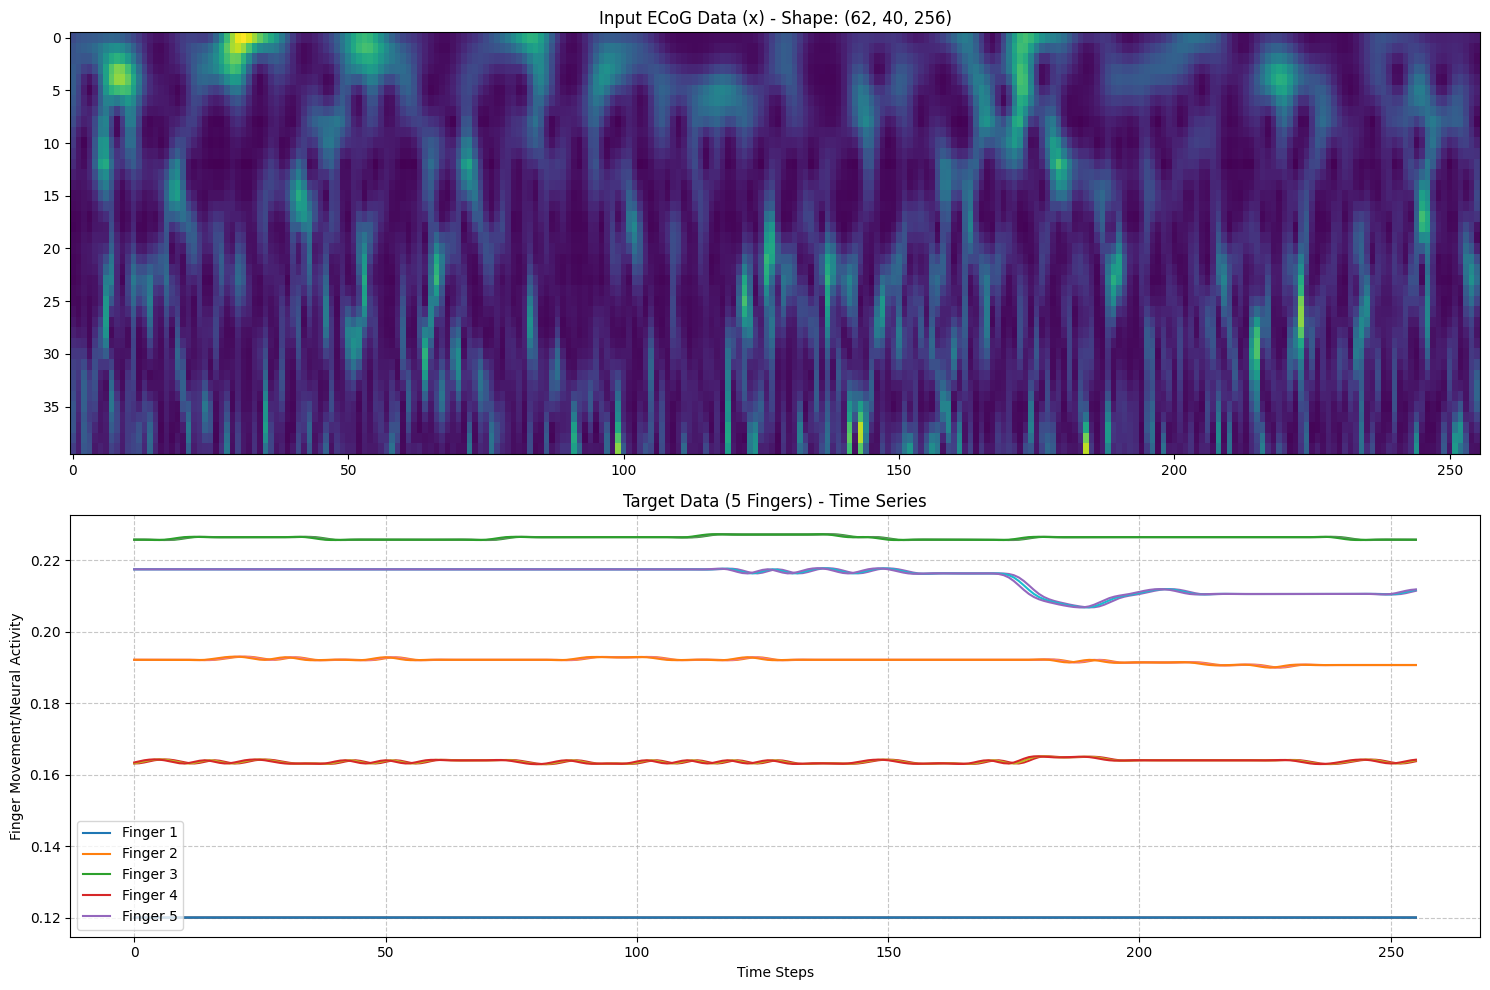

Input (x) Data Statistics:
Shape: (62, 40, 256)
Mean: 36.44956970214844
Std: 112.34618377685547
Min: -78.30249786376953
Max: 2913.20654296875

Target (y) Data Statistics:
Shape: (5, 256)
Mean: 0.18342195451259613
Std: 0.038283176720142365
Min: 0.12006422877311707
Max: 0.22728414833545685


In [17]:
def plot_ecog_data(train_dataset):
    # Assuming train_dataset is a PyTorch Dataset
    # Extract a few samples to visualize
    
    # Create a figure with subplots
    fig, axs = plt.subplots(2, 1, figsize=(15, 10))
    
    # Get a few samples (let's take the first 3)
    for i in range(min(3, len(train_dataset))):
        x, y = train_dataset[i]
        
        # Plot input data (x)
        axs[0].set_title('Input ECoG Data (x) - Shape: ' + str(x.shape))
        # Assuming x is (62, 40, timeseries)
        # We'll plot a few channels/slices
        im = axs[0].imshow(x[0, :, :], aspect='auto', cmap='viridis')
        
        # Plot target data (y)
        plt.title('Target Data (5 Fingers) - Time Series')
        plt.plot(y.T)
        plt.xlabel('Time Steps')
        plt.ylabel('Finger Movement/Neural Activity')
        plt.legend([f'Finger {i+1}' for i in range(y.shape[0])])
        plt.grid(True, linestyle='--', alpha=0.7)
    
    plt.tight_layout()
    plt.show()
    
    # Additional statistical analysis
    x, y = train_dataset[0]
    print("Input (x) Data Statistics:")
    print(f"Shape: {x.shape}")
    print(f"Mean: {x.mean()}")
    print(f"Std: {x.std()}")
    print(f"Min: {x.min()}")
    print(f"Max: {x.max()}")
    
    print("\nTarget (y) Data Statistics:")
    print(f"Shape: {y.shape}")
    print(f"Mean: {y.mean()}")
    print(f"Std: {y.std()}")
    print(f"Min: {y.min()}")
    print(f"Max: {y.max()}")

# Call the visualization function
plot_ecog_data(train_dataset)